### Import all the libraries

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Load each dataset

In [62]:
online_sales = pd.read_csv('Online_Sales.csv', parse_dates=['Transaction_Date'])
customers = pd.read_excel('CustomersData.xlsx')
discount_coupon = pd.read_csv('Discount_Coupon.csv')
marketing = pd.read_csv('Marketing_Spend.csv', parse_dates=['Date'])
tax_amount = pd.read_excel('Tax_amount.xlsx')

In [63]:
print(online_sales.head())
print(discount_coupon.head())
print(tax_amount.head())
print(customers.head())
print(marketing.head())

   CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
0       17850           16679       2019-01-01  GGOENEBJ079499   
1       17850           16680       2019-01-01  GGOENEBJ079499   
2       17850           16681       2019-01-01  GGOEGFKQ020399   
3       17850           16682       2019-01-01  GGOEGAAB010516   
4       17850           16682       2019-01-01  GGOEGBJL013999   

                                 Product_Description Product_Category  \
0  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
1  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
2              Google Laptop and Cell Phone Stickers           Office   
3  Google Men's 100% Cotton Short Sleeve Hero Tee...          Apparel   
4                    Google Canvas Tote Natural/Navy             Bags   

   Quantity  Avg_Price  Delivery_Charges Coupon_Status  
0         1     153.71               6.5          Used  
1         1     153.71               6.5          

In [64]:
## Convert Month name into month number
discount_coupon['Month'] = pd.to_datetime(discount_coupon['Month'], format='%b').dt.month

In [65]:
## Convert date into month number.
marketing['Month'] = marketing['Date'].dt.to_period('M')
marketing['Month'] = marketing['Month'].dt.month

### Merging dataframes to include discount and tax information

In [66]:
merged_data = online_sales.merge(discount_coupon, on='Product_Category', how='left')
merged_data = merged_data.merge(tax_amount, on='Product_Category', how='left')

In [67]:
merged_data = merged_data.merge(customers, on='CustomerID', how = 'left')

In [68]:
merged_data.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST,Gender,Location,Tenure_Months
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,1.0,ELEC10,10.0,0.1,M,Chicago,12
1,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2.0,ELEC20,20.0,0.1,M,Chicago,12
2,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,3.0,ELEC30,30.0,0.1,M,Chicago,12
3,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,4.0,ELEC10,10.0,0.1,M,Chicago,12
4,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,5.0,ELEC20,20.0,0.1,M,Chicago,12


In [69]:
merged_data.shape

(630688, 17)

### Identifying the missing values

In [70]:
merged_data.isnull().sum()

CustomerID               0
Transaction_ID           0
Transaction_Date         0
Product_SKU              0
Product_Description      0
Product_Category         0
Quantity                 0
Avg_Price                0
Delivery_Charges         0
Coupon_Status            0
Month                  400
Coupon_Code            400
Discount_pct           400
GST                      0
Gender                   0
Location                 0
Tenure_Months            0
dtype: int64

### Handling missing values

In [71]:
merged_data['Discount_pct'] = merged_data['Discount_pct'].fillna(0) 

In [72]:
merged_data.isnull().sum()

CustomerID               0
Transaction_ID           0
Transaction_Date         0
Product_SKU              0
Product_Description      0
Product_Category         0
Quantity                 0
Avg_Price                0
Delivery_Charges         0
Coupon_Status            0
Month                  400
Coupon_Code            400
Discount_pct             0
GST                      0
Gender                   0
Location                 0
Tenure_Months            0
dtype: int64

###  Convert dates to datetime format

In [73]:
online_sales['Transaction_Date'] = pd.to_datetime(online_sales['Transaction_Date'])
marketing['Date'] = pd.to_datetime(marketing['Date'])

In [74]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630688 entries, 0 to 630687
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   CustomerID           630688 non-null  int64         
 1   Transaction_ID       630688 non-null  int64         
 2   Transaction_Date     630688 non-null  datetime64[ns]
 3   Product_SKU          630688 non-null  object        
 4   Product_Description  630688 non-null  object        
 5   Product_Category     630688 non-null  object        
 6   Quantity             630688 non-null  int64         
 7   Avg_Price            630688 non-null  float64       
 8   Delivery_Charges     630688 non-null  float64       
 9   Coupon_Status        630688 non-null  object        
 10  Month                630288 non-null  float64       
 11  Coupon_Code          630288 non-null  object        
 12  Discount_pct         630688 non-null  float64       
 13  GST           

###  Calculate Invoice Value

In [75]:
merged_data['Invoice_Value'] = ((merged_data['Quantity'] * merged_data['Avg_Price']) *
                                 (1 - merged_data['Discount_pct'].fillna(0)) *
                                 (1 + merged_data['GST'].fillna(0))) + merged_data['Delivery_Charges']
merged_data.head(2)

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST,Gender,Location,Tenure_Months,Invoice_Value
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,1.0,ELEC10,10.0,0.1,M,Chicago,12,-1515.229
1,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2.0,ELEC20,20.0,0.1,M,Chicago,12,-3206.039


In [76]:
merged_data.shape

(630688, 18)

In [77]:
merged_data['Invoice_Value'] = (
    (merged_data['Quantity'] * merged_data['Avg_Price']) *
    (1 - merged_data['Discount_pct'].fillna(0)) *
    (1 + merged_data['GST'].fillna(0)) +
    merged_data['Delivery_Charges'].fillna(0)
)

# Display the updated DataFrame
print(merged_data[['Transaction_ID', 'Invoice_Value']])

        Transaction_ID  Invoice_Value
0                16679      -1515.229
1                16679      -3206.039
2                16679      -4896.849
3                16679      -1515.229
4                16679      -3206.039
...                ...            ...
630683           48497      -6711.482
630684           48497     -10254.362
630685           48497      -3168.602
630686           48497      -6711.482
630687           48497     -10254.362

[630688 rows x 2 columns]


## Exploratory Data Analysis

In [78]:
### a. Customer Acquisition by Month

In [79]:
# Extract month and year
merged_data['YearMonth'] = merged_data['Transaction_Date'].dt.to_period('M')

In [80]:
# Count unique customers acquired each month
customer_acquisition = merged_data.groupby('YearMonth')['CustomerID'].nunique().reset_index()

print(customer_acquisition)

   YearMonth  CustomerID
0    2019-01         215
1    2019-02         109
2    2019-03         208
3    2019-04         224
4    2019-05         200
5    2019-06         259
6    2019-07         236
7    2019-08         300
8    2019-09         193
9    2019-10         210
10   2019-11         188
11   2019-12         236


In [81]:
## b. Customer Retention Month on Month

In [82]:
# Identify first transaction month for each customer
first_purchase = merged_data.groupby('CustomerID')['YearMonth'].min().reset_index()
first_purchase.columns = ['CustomerID', 'FirstPurchaseMonth']

In [83]:
# Merge to identify retained customers
merged_data = pd.merge(merged_data, first_purchase, on='CustomerID', how='left')

In [84]:
# Count customers retained in subsequent months
retention = merged_data.groupby(['YearMonth', 'FirstPurchaseMonth']).agg({'CustomerID': 'nunique'}).reset_index()

print(retention)


   YearMonth FirstPurchaseMonth  CustomerID
0    2019-01            2019-01         215
1    2019-02            2019-01          13
2    2019-02            2019-02          96
3    2019-03            2019-01          24
4    2019-03            2019-02           7
..       ...                ...         ...
73   2019-12            2019-08           8
74   2019-12            2019-09           2
75   2019-12            2019-10           4
76   2019-12            2019-11           7
77   2019-12            2019-12         106

[78 rows x 3 columns]


In [85]:
# c. Revenue from Existing/New Customers Month on Month

In [86]:
# Identify new and returning customers
merged_data['IsNewCustomer'] = merged_data['FirstPurchaseMonth'] == merged_data['YearMonth']

In [87]:
# Aggregate revenue by month and customer type
revenue_by_customer_type = merged_data.groupby(['YearMonth', 'IsNewCustomer'])['Invoice_Value'].sum().reset_index()

print(revenue_by_customer_type)


   YearMonth  IsNewCustomer  Invoice_Value
0    2019-01           True  -1.010557e+08
1    2019-02          False  -9.881221e+06
2    2019-02           True  -6.815853e+07
3    2019-03          False  -1.333226e+07
4    2019-03           True  -7.441387e+07
5    2019-04          False  -4.239951e+07
6    2019-04           True  -5.870128e+07
7    2019-05          False  -2.773858e+07
8    2019-05           True  -4.954176e+07
9    2019-06          False  -3.258802e+07
10   2019-06           True  -4.841579e+07
11   2019-07          False  -5.606999e+07
12   2019-07           True  -3.752874e+07
13   2019-08          False  -5.227884e+07
14   2019-08           True  -4.819625e+07
15   2019-09          False  -5.370870e+07
16   2019-09           True  -3.676857e+07
17   2019-10          False  -4.774471e+07
18   2019-10           True  -5.382525e+07
19   2019-11          False  -7.208282e+07
20   2019-11           True  -5.383968e+07
21   2019-12          False  -6.878438e+07
22   2019-1

In [88]:
# d Impact of Discounts on Revenue

In [89]:
# Group by month and discount status
discount_impact = merged_data.groupby(['YearMonth', 'Coupon_Status'])['Invoice_Value'].sum().reset_index()

print(discount_impact)


   YearMonth Coupon_Status  Invoice_Value
0    2019-01       Clicked  -5.344697e+07
1    2019-01      Not Used  -1.496258e+07
2    2019-01          Used  -3.264610e+07
3    2019-02       Clicked  -4.085410e+07
4    2019-02      Not Used  -1.263998e+07
5    2019-02          Used  -2.454567e+07
6    2019-03       Clicked  -4.439514e+07
7    2019-03      Not Used  -1.468475e+07
8    2019-03          Used  -2.866623e+07
9    2019-04       Clicked  -5.205165e+07
10   2019-04      Not Used  -1.488352e+07
11   2019-04          Used  -3.416562e+07
12   2019-05       Clicked  -4.149240e+07
13   2019-05      Not Used  -1.180214e+07
14   2019-05          Used  -2.398580e+07
15   2019-06       Clicked  -3.935465e+07
16   2019-06      Not Used  -1.443700e+07
17   2019-06          Used  -2.721216e+07
18   2019-07       Clicked  -4.804445e+07
19   2019-07      Not Used  -1.517046e+07
20   2019-07          Used  -3.038383e+07
21   2019-08       Clicked  -4.959541e+07
22   2019-08      Not Used  -1.562

C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


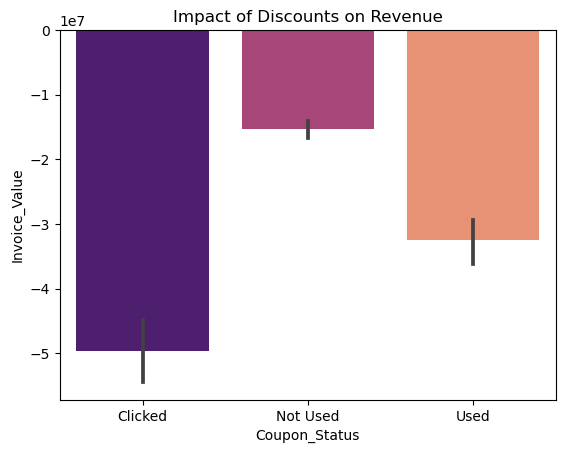

In [90]:
sns.barplot(data=discount_impact, x='Coupon_Status', y='Invoice_Value', palette='magma')
plt.title('Impact of Discounts on Revenue')
plt.show()

In [91]:
# e. KPIs Analysis

In [92]:
# Calculate KPIs
kpi_summary = merged_data.groupby('YearMonth').agg({
    'Invoice_Value': 'sum',
    'Transaction_ID': 'count',
    'CustomerID': 'nunique',
    'Quantity': 'sum'
}).reset_index()

kpi_summary['Average_Order_Value'] = kpi_summary['Invoice_Value'] / kpi_summary['Transaction_ID']
print(kpi_summary)

   YearMonth  Invoice_Value  Transaction_ID  CustomerID  Quantity  \
0    2019-01  -1.010557e+08           48316         215    239997   
1    2019-02  -7.803975e+07           38979         109    197085   
2    2019-03  -8.774612e+07           51536         208    246760   
3    2019-04  -1.011008e+08           49228         224    299419   
4    2019-05  -7.728034e+07           54248         200    222424   
5    2019-06  -8.100380e+07           49942         259    257921   
6    2019-07  -9.359873e+07           62407         236    271641   
7    2019-08  -1.004751e+08           73382         300    328626   
8    2019-09  -9.047727e+07           51291         193    231972   
9    2019-10  -1.015700e+08           49847         210    208825   
10   2019-11  -1.259225e+08           47488         188    181396   
11   2019-12  -1.303679e+08           54024         236    152004   

    Average_Order_Value  
0          -2091.556721  
1          -2002.097363  
2          -1702.618044 

In [93]:
#f Trends and Seasonality of Sales by Category and Location

C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if

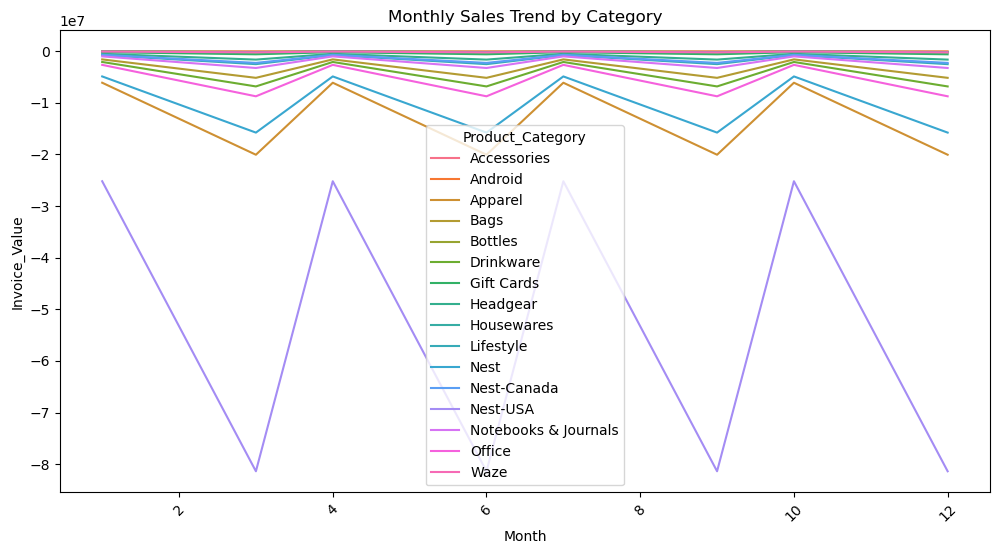

In [94]:
# Monthly Sales Trend by Product Category
category_trend = merged_data.groupby(['Month', 'Product_Category'])['Invoice_Value'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=category_trend, x='Month', y='Invoice_Value', hue='Product_Category')
plt.title('Monthly Sales Trend by Category')
plt.xticks(rotation=45)
plt.show()


C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


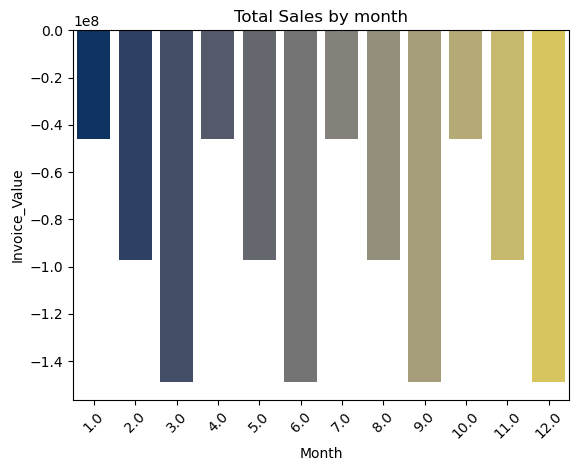

In [95]:
# Sales by Month
sales_by_location = merged_data.groupby('Month')['Invoice_Value'].sum().reset_index()
sns.barplot(data=sales_by_location, x='Month', y='Invoice_Value', palette='cividis')
plt.title('Total Sales by month')
plt.xticks(rotation=45)
plt.show()


In [96]:
# g. Marketing Spend and its Impact on Revenue

In [97]:
# Merge Revenue with Marketing Data
monthly_revenue = merged_data.groupby('Month')['Invoice_Value'].sum().reset_index()

In [98]:
revenue_vs_spend = pd.merge(monthly_revenue, marketing.groupby('Month').count().reset_index(), on='Month')

C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

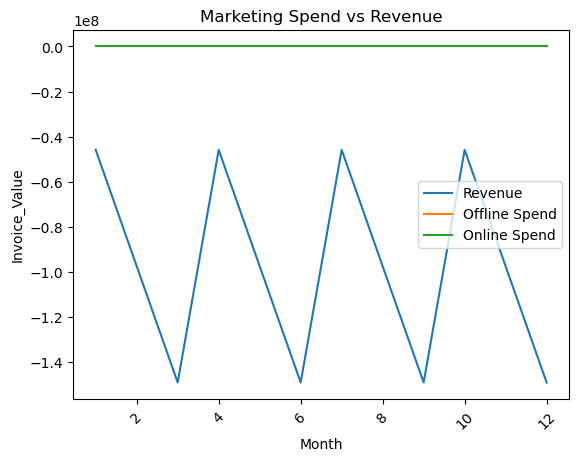

In [99]:

# Calculate Percentage of Marketing Spend from Revenue
revenue_vs_spend['Marketing_Percentage'] = (revenue_vs_spend['Offline_Spend'] + revenue_vs_spend['Online_Spend']) / revenue_vs_spend['Invoice_Value'] * 100

sns.lineplot(data=revenue_vs_spend, x='Month', y='Invoice_Value', label='Revenue')
sns.lineplot(data=revenue_vs_spend, x='Month', y='Offline_Spend', label='Offline Spend')
sns.lineplot(data=revenue_vs_spend, x='Month', y='Online_Spend', label='Online Spend')
plt.title('Marketing Spend vs Revenue')
plt.xticks(rotation=45)
plt.show()


In [100]:
# h. Top Products by Quantity Purchased


In [101]:
# Most Frequently Purchased Products
top_products = merged_data.groupby('Product_Description')['Quantity'].sum().reset_index()
top_products = top_products.sort_values(by='Quantity', ascending=False).head(10)



C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


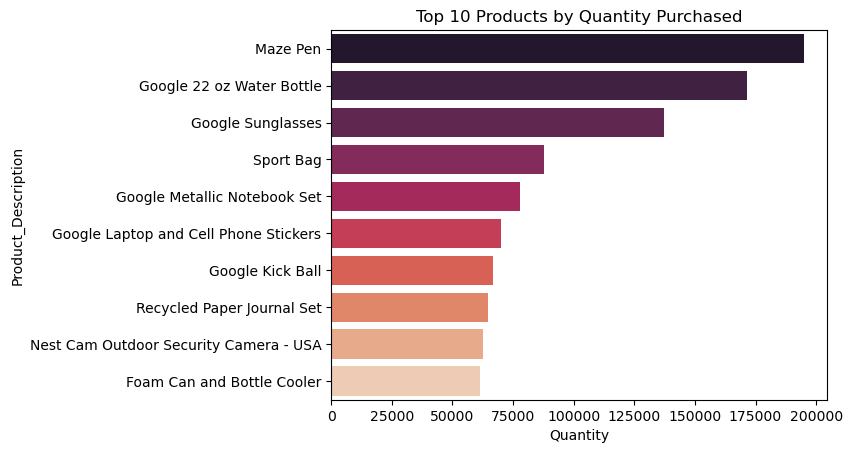

In [102]:
sns.barplot(data=top_products, x='Quantity', y='Product_Description', palette='rocket')
plt.title('Top 10 Products by Quantity Purchased')
plt.show()


In [103]:
top_products.head()

,Product_Description,Quantity
301,Maze Pen,194808
101,Google 22 oz Water Bottle,171384
212,Google Sunglasses,137424
340,Sport Bag,87852
192,Google Metallic Notebook Set,77952


## 3. Performing Customer Segmentation
#### a. Heuristic Segmentation

In [104]:
# You can segment customers based on their total spending.
# Calculate total revenue per customer
customer_revenue = merged_data.groupby('CustomerID')['Invoice_Value'].sum().reset_index()

# Define segments based on revenue
conditions = [
    (customer_revenue['Invoice_Value'] > 1000),  # Premium
    (customer_revenue['Invoice_Value'] > 500),   # Gold
    (customer_revenue['Invoice_Value'] > 100)    # Silver
]
choices = ['Premium', 'Gold', 'Silver', 'Standard']

customer_revenue['Segment'] = pd.cut(customer_revenue['Invoice_Value'], bins=[0, 100, 500, 1000, float('inf')],
                                      labels=['Standard', 'Silver', 'Gold', 'Premium'], right=False)

print(customer_revenue[['CustomerID', 'Invoice_Value', 'Segment']])


      CustomerID  Invoice_Value Segment
0          12346  -6.336910e+03     NaN
1          12347  -3.612292e+06     NaN
2          12348  -3.728585e+05     NaN
3          12350  -3.423656e+05     NaN
4          12356  -3.558345e+05     NaN
...          ...            ...     ...
1463       18259  -1.277661e+05     NaN
1464       18260  -5.819369e+05     NaN
1465       18269  -2.664770e+04     NaN
1466       18277  -7.466640e+04     NaN
1467       18283  -1.571241e+06     NaN

[1468 rows x 3 columns]


In [105]:
# Set the analysis date as the last transaction date in the dataset
analysis_date = online_sales['Transaction_Date'].max() + pd.DateOffset(1)

# Calculate Recency, Frequency, and Monetary values for each customer
rfm = online_sales.groupby('CustomerID').agg({
    'Transaction_Date': lambda x: (analysis_date - x.max()).days,  # Recency
    'Transaction_ID': 'nunique',  # Frequency (count of transactions)
    'Avg_Price': 'sum'  # Monetary value (sum of all purchases)
}).reset_index()

# Rename the columns for clarity
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Preview the RFM table
print(rfm.head())


   CustomerID  Recency  Frequency  Monetary
0       12346      108          1     25.49
1       12347       60         31   3746.16
2       12348       74          8    336.52
3       12350       18         11   1312.40
4       12356      108         13   1244.83


C:\Users\hp\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\hp\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\hp\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

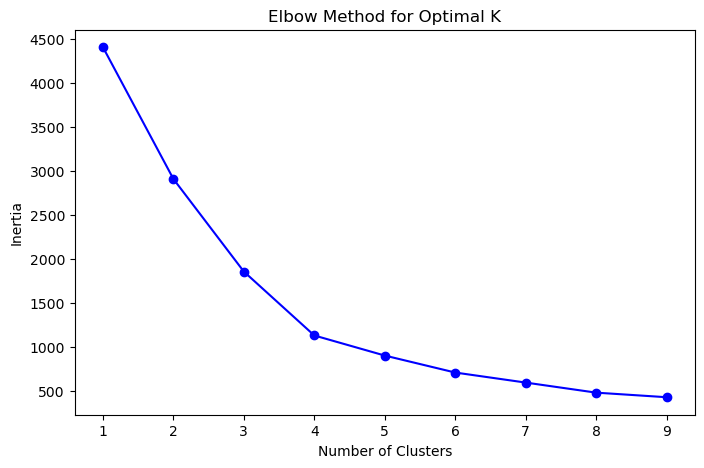

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   Cluster  Avg_Recency  Avg_Frequency  Avg_Monetary  Customer_Count
0        0   255.378182      10.250909    972.562836             550
1        1    77.598985      52.370558   5770.536041             197
2        2    66.125000     242.375000  25804.276250               8
3        3    79.964937      12.253857   1243.318135             713


C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


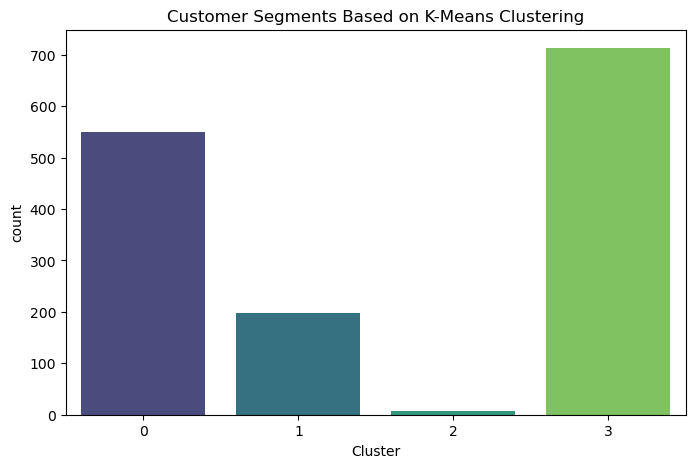

In [106]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use Recency, Frequency, and Monetary as features
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Elbow Method to Find Optimal Number of Clusters
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Apply K-Means with Optimal K (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Display Cluster Profiles
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).reset_index()
cluster_profile.columns = ['Cluster', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Customer_Count']

print(cluster_profile)

# Plot Cluster Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=rfm, x='Cluster', palette='viridis')
plt.title('Customer Segments Based on K-Means Clustering')
plt.show()


## 4 Define CLV categories based on revenue

In [107]:
# If you want to create four categories, you need five edges.
# a  Create CLV Categories based on revenue
merged_data['CLV_Category'] = pd.qcut(merged_data['Invoice_Value'], 3, labels=['Low', 'Medium', 'High'])

In [108]:
#### b Training a Classification Model to Predict CLV

In [109]:
# Prepare data
X = merged_data[['Quantity', 'Avg_Price', 'Discount_pct']]
y = merged_data['CLV_Category']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Evaluate the model
accuracy = clf.score(X_test, y_test)
print(f'Model Accuracy: {accuracy:.2f}')

C:\Users\hp\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\hp\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\hp\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

Model Accuracy: 0.99


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


## 5 Market Basket Analysis Using Association Rules

In [110]:
import mlxtend
from mlxtend.frequent_patterns import apriori, association_rules

# Create Basket Data for Market Basket Analysis
basket = merged_data.pivot_table(index='Transaction_ID', columns='Product_SKU', values='Quantity', aggfunc='sum').fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Apply Apriori Algorithm
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

print(rules.head())

C:\Users\hp\AppData\Local\Temp\ipykernel_10952\919412224.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)
C:\Users\hp\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


        antecedents       consequents  antecedent support  consequent support  \
0  (GGOEGHGR019499)  (GGOEGHGC019799)            0.014644            0.017677   
1  (GGOEGHGC019799)  (GGOEGHGR019499)            0.017677            0.014644   
2  (GGOENEBQ078999)  (GGOENEBB078899)            0.132796            0.128886   
3  (GGOENEBB078899)  (GGOENEBQ078999)            0.128886            0.132796   

    support  confidence       lift  leverage  conviction  zhangs_metric  
0  0.010654    0.727520  41.156636  0.010395    3.605126       0.990203  
1  0.010654    0.602709  41.156636  0.010395    2.480185       0.993260  
2  0.027653    0.208233   1.615644  0.010537    1.100216       0.439403  
3  0.027653    0.214551   1.615644  0.010537    1.104087       0.437430  


## 6. Predicting Next Purchase Day

In [111]:
## a. Creating Dependent Variable
# Predicting Next Purchase Day
merged_data['Days_Between'] = merged_data.groupby('CustomerID')['Transaction_Date'].diff().dt.days
bins = [0, 30, 60, 90, float('inf')]
labels = ['0-30 days', '30-60 days', '60-90 days', '90+ days']
merged_data['Next_Purchase_Group'] = pd.cut(merged_data['Days_Between'], bins=bins, labels=labels)

print(merged_data[['CustomerID', 'Days_Between', 'Next_Purchase_Group']].head())

   CustomerID  Days_Between Next_Purchase_Group
0       17850           NaN                 NaN
1       17850           0.0                 NaN
2       17850           0.0                 NaN
3       17850           0.0                 NaN
4       17850           0.0                 NaN


C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


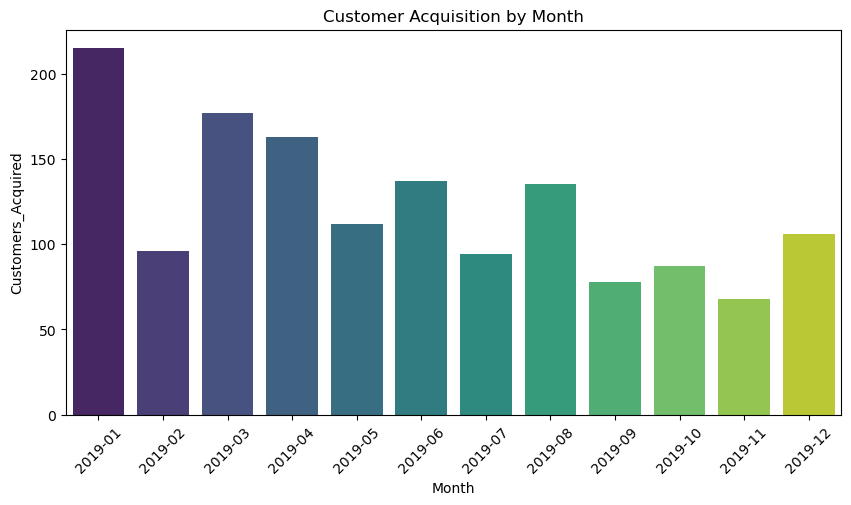

In [112]:
# Extract Month of First Purchase for each customer
online_sales['Transaction_Date'] = pd.to_datetime(online_sales['Transaction_Date'])
online_sales['Month'] = online_sales['Transaction_Date'].dt.to_period('M')

first_purchase = online_sales.groupby('CustomerID')['Month'].min().reset_index()
first_purchase.columns = ['CustomerID', 'First_Purchase_Month']

# Count number of customers acquired each month
customers_acquired = first_purchase.groupby('First_Purchase_Month')['CustomerID'].count().reset_index()
customers_acquired.columns = ['Month', 'Customers_Acquired']

# Plotting Customer Acquisition
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(data=customers_acquired, x='Month', y='Customers_Acquired', palette='viridis')
plt.xticks(rotation=45)
plt.title('Customer Acquisition by Month')
plt.show()


## 7 Cohort Analysis

In [113]:
## Retention of Customers Month-on-Month
merged_data['Cohort_Month'] = merged_data.groupby('CustomerID')['Transaction_Date'].transform('min').dt.to_period('M')
cohort = merged_data.pivot_table(
    index='Cohort_Month', 
    columns=merged_data['Transaction_Date'].dt.to_period('M'), 
    values='CustomerID', 
    aggfunc='nunique'
).fillna(0)

print(cohort)

Transaction_Date  2019-01  2019-02  2019-03  2019-04  2019-05  2019-06  \
Cohort_Month                                                             
2019-01             215.0     13.0     24.0     34.0     23.0     44.0   
2019-02               0.0     96.0      7.0      9.0     16.0     17.0   
2019-03               0.0      0.0    177.0     18.0     35.0     25.0   
2019-04               0.0      0.0      0.0    163.0     14.0     24.0   
2019-05               0.0      0.0      0.0      0.0    112.0     12.0   
2019-06               0.0      0.0      0.0      0.0      0.0    137.0   
2019-07               0.0      0.0      0.0      0.0      0.0      0.0   
2019-08               0.0      0.0      0.0      0.0      0.0      0.0   
2019-09               0.0      0.0      0.0      0.0      0.0      0.0   
2019-10               0.0      0.0      0.0      0.0      0.0      0.0   
2019-11               0.0      0.0      0.0      0.0      0.0      0.0   
2019-12               0.0      0.0    

In [114]:
# Create cohort groups
online_sales['CohortMonth'] = online_sales['Transaction_Date'].dt.to_period('M')

# Group by cohort and count customers
cohort_data = online_sales.groupby(['CohortMonth', 'CustomerID']).size().reset_index(name='Frequency')
cohort_retention = cohort_data.groupby('CohortMonth')['CustomerID'].nunique().reset_index()
cohort_retention.head()


,CohortMonth,CustomerID
0,2019-01,215
1,2019-02,109
2,2019-03,208
3,2019-04,224
4,2019-05,200
